In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve, auc, classification_report
from datasets import Dataset
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# -----------------------
# Load and Prepare Dataset
# -----------------------
df = pd.read_csv("train.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df = df.dropna(subset=['comment_text'])
df[label_cols] = df[label_cols].astype(int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [8]:
# -----------------------
# Tokenization
# -----------------------
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["comment_text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/127656 [00:00<?, ? examples/s]

Map:   0%|          | 0/31915 [00:00<?, ? examples/s]

In [9]:
# Convert labels to float for BCE loss
train_dataset = train_dataset.map(lambda x: {"labels": [float(x[col]) for col in label_cols]})
test_dataset = test_dataset.map(lambda x: {"labels": [float(x[col]) for col in label_cols]})

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/127656 [00:00<?, ? examples/s]

Map:   0%|          | 0/31915 [00:00<?, ? examples/s]

In [ ]:
# -----------------------
# Model
# -----------------------
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_cols),
    problem_type="multi_label_classification"
)

In [11]:
# -----------------------
# Metrics
# -----------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs >= 0.5).astype(int)

    f1 = f1_score(labels, preds, average="macro")
    roc_auc = roc_auc_score(labels, probs, average="macro")
    acc = accuracy_score(labels, preds)
    return {"f1": f1, "roc_auc": roc_auc, "accuracy": acc}


In [12]:
# -----------------------
# Training Arguments
# -----------------------

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",              # Save checkpoint each epoch
    learning_rate=3e-5,                 # Reasonable learning rate for DistilBERT
    per_device_train_batch_size=16,     # Smaller batch size for faster iteration
    per_device_eval_batch_size=16,
    num_train_epochs=2,                 # Reduce epochs for quick training
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,                   # Log less frequently
    load_best_model_at_end=True,
    metric_for_best_model="f1",         # Use F1 to track best model
    greater_is_better=True,
    fp16=True,                          # Use mixed precision (if GPU supports it)
    report_to="none",                   # Disable W&B or other tracking
)


In [13]:
# -----------------------
# Trainer
# -----------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-1766523779.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.039400,0.037591,0.585305,0.990503,0.928529
2,0.033900,0.037710,0.652874,0.990904,0.929845


TrainOutput(global_step=15958, training_loss=0.03898922043082962, metrics={'train_runtime': 1097.4724, 'train_samples_per_second': 232.636, 'train_steps_per_second': 14.541, 'total_flos': 8455732262313984.0, 'train_loss': 0.03898922043082962, 'epoch': 2.0})

In [14]:
# -----------------------
# Evaluation and Predictions
# -----------------------
results = trainer.evaluate()
print("\n📊 Evaluation Results:", results)

# Predict probabilities and binary labels
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
probs = 1 / (1 + np.exp(-logits))
binary_preds = (probs >= 0.5).astype(int)


📊 Evaluation Results: {'eval_loss': 0.03771020472049713, 'eval_f1': 0.652873913401266, 'eval_roc_auc': 0.9909041235547762, 'eval_accuracy': 0.9298449005169983, 'eval_runtime': 33.3571, 'eval_samples_per_second': 956.769, 'eval_steps_per_second': 59.807, 'epoch': 2.0}


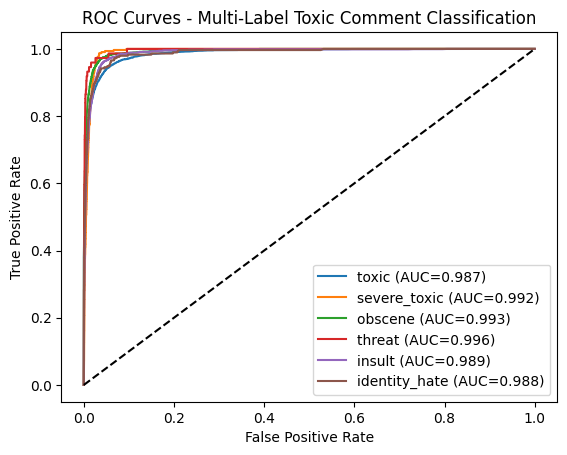

In [15]:
# -----------------------
# Plot ROC Curves
# -----------------------
for i, label in enumerate(label_cols):
    fpr, tpr, _ = roc_curve(predictions.label_ids[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc(fpr, tpr):.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Multi-Label Toxic Comment Classification")
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import classification_report, roc_auc_score

# Get true and predicted labels
y_true = predictions.label_ids
y_probs = probs
y_pred = binary_preds

label_names = label_cols
# 🔹 Detailed classification report (Precision, Recall, F1)
report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
print("Classification Report (Per Label):")
for label in label_names:
    print(f"{label:15s} | Precision: {report[label]['precision']:.3f} | "
          f"Recall: {report[label]['recall']:.3f} | "
          f"F1-score: {report[label]['f1-score']:.3f}")

Classification Report (Per Label):
toxic           | Precision: 0.848 | Recall: 0.833 | F1-score: 0.840
severe_toxic    | Precision: 0.608 | Recall: 0.290 | F1-score: 0.392
obscene         | Precision: 0.853 | Recall: 0.837 | F1-score: 0.845
threat          | Precision: 0.547 | Recall: 0.473 | F1-score: 0.507
insult          | Precision: 0.773 | Recall: 0.787 | F1-score: 0.780
identity_hate   | Precision: 0.678 | Recall: 0.466 | F1-score: 0.552


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# 🔹 AUROC for each label
print("\nAUROC Scores (Per Label):")
for i, label in enumerate(label_names):
    auc_score = roc_auc_score(y_true[:, i], y_probs[:, i])
    print(f"{label:15s} | AUC: {auc_score:.3f}")


AUROC Scores (Per Label):
toxic           | AUC: 0.987
severe_toxic    | AUC: 0.992
obscene         | AUC: 0.993
threat          | AUC: 0.996
insult          | AUC: 0.989
identity_hate   | AUC: 0.988


In [18]:
# -----------------------
# 🔮 Real-world Prediction
# -----------------------
def predict_text(text):
    # Tokenize input
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(model.device)

    # Get model outputs
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    # Binary predictions (threshold 0.5)
    preds = (probs >= 0.5).astype(int)

    # Prepare readable output
    results = {label_cols[i]: float(probs[i]) for i in range(len(label_cols))}
    binary_results = {label_cols[i]: int(preds[i]) for i in range(len(label_cols))}

    return results, binary_results


In [19]:
# Example usage
sample_text = "You are such an idiot, stop posting nonsense!"
predict_text(sample_text)

({'toxic': 0.994551956653595,
  'severe_toxic': 0.028328312560915947,
  'obscene': 0.6523521542549133,
  'threat': 0.002034817123785615,
  'insult': 0.9405717849731445,
  'identity_hate': 0.00937623716890812},
 {'toxic': 1,
  'severe_toxic': 0,
  'obscene': 1,
  'threat': 0,
  'insult': 1,
  'identity_hate': 0})

In [20]:
from tqdm import tqdm

# Load your test dataset
test_df = pd.read_csv("test.csv")

# Prepare lists to store results
all_probs = []
all_preds = []

# Set model to evaluation mode
model.eval()

# Disable gradient calculation for faster inference
with torch.no_grad():
    for text in tqdm(test_df["comment_text"], desc="Predicting"):
        # Tokenize
        inputs = tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(model.device)

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]
        preds = (probs >= 0.5).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)

# Convert to DataFrames
prob_df = pd.DataFrame(all_probs, columns=[f"{col}_prob" for col in label_cols])
pred_df = pd.DataFrame(all_preds, columns=label_cols)

# Combine with IDs and comments
final_df = pd.concat([test_df[["id", "comment_text"]].reset_index(drop=True), pred_df], axis=1)


Predicting: 100%|██████████| 153164/153164 [16:05<00:00, 158.69it/s]


In [21]:
final_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,1,0,1,0,1,1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,0,0,0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",1,0,0,0,0,0
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,0,0,0,0,0,0
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",0,0,0,0,0,0
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",0,0,0,0,0,0


In [22]:
final_df.to_csv('test_result.csv', index=False)

In [23]:
# -----------------------
# Save Model
# -----------------------
# Save the model
trainer.save_model("./toxic_comment_model")

print("Model saved successfully to ./toxic_comment_model")

Model saved successfully to ./toxic_comment_model


In [24]:
import shutil
import os

# Define the directory to be zipped and the name of the zip file
directory_to_zip = "./toxic_comment_model"
zip_file_name = "toxic_comment_model.zip"

# Create the zip file
shutil.make_archive(zip_file_name.replace('.zip', ''), 'zip', directory_to_zip)

print(f"'{directory_to_zip}' has been zipped to '{zip_file_name}'. You can now download this file from the file browser.")

'./toxic_comment_model' has been zipped to 'toxic_comment_model.zip'. You can now download this file from the file browser.
